In [32]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# %pip install numpy
# %pip install matplotlib
# %pip install rasterio
# %pip install sat-search pyproj rasterio[s3] pyproj
# %pip install torchgeo

In [74]:
import satsearch
from json import load
import rasterio as rio
from rasterio.plot import show
from IPython.display import Image
import matplotlib.pyplot as plt

import torch
import numpy as np

In [27]:
file_path = "../data/map.geojson"
file_content = load(open(file_path))
geometry = file_content["features"][0]["geometry"]
timeRange = "2022-01-01/2022-08-27"

In [28]:
SentinelSearch = satsearch.Search.search(
    url="https://earth-search.aws.element84.com/v0",
    intersects=geometry,
    datetime=timeRange,
    collections=["sentinel-s2-l2a-cogs"],
)

items = SentinelSearch.items()

In [ ]:
keys = set([k for i in items for k in i.assets])

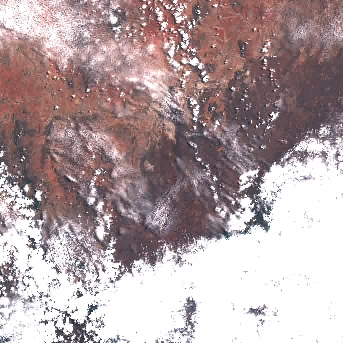

In [30]:
# Visualize some items thumbnail
Image(items[0].assets["thumbnail"]["href"])

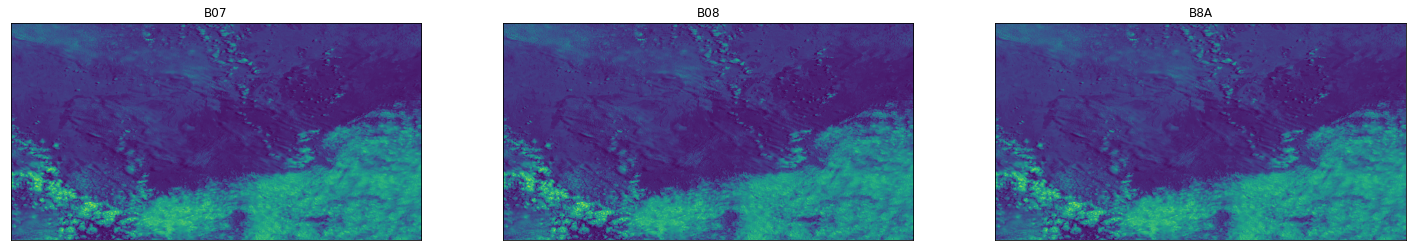

In [31]:
# some bands
bands = ["B07", "B08", "B8A"]
fig = plt.figure(figsize=(25, 4))
for idx in range(len(bands)):
    ax = fig.add_subplot(1, 3, idx + 1, xticks=[], yticks=[])
    plt.imshow(rio.open(items[0].assets[bands[idx]]["href"]).read(1), aspect="auto")
    ax.set_title(bands[idx])

In [43]:
# Some band combinations
# agriculture and true color bands B11, B8, B2, B4, B3, B2

# Natural color
R = items[0].assets["B04"]["href"]
G = items[0].assets["B03"]["href"]
B = items[0].assets["B02"]["href"]

# agriculture
B8 = items[0].assets["B08"]["href"]
B11 = items[0].assets["B11"]["href"]

items[0].assets["B04"]["proj:shape"]

[10980, 10980]

In [36]:
items[0].assets["B04"]

{'title': 'Band 4 (red)',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'roles': ['data'],
 'gsd': 10,
 'eo:bands': [{'name': 'B04',
   'common_name': 'red',
   'center_wavelength': 0.6645,
   'full_width_half_max': 0.038}],
 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B04.tif',
 'proj:shape': [10980, 10980],
 'proj:transform': [10, 0, 300000, 0, -10, 100020, 0, 0, 1]}

In [45]:
# Process and save natural color tiff
R = rio.open(items[0].assets["B04"]["href"])  # get info from red band
true_color = rio.open(
    "../data/sentinel/sample.tiff",
    "w",
    driver="Gtiff",
    width=R.width,
    height=R.height,
    count=3,
    crs=R.crs,
    transform=R.transform,
    dtype=R.dtypes[0],
)
true_color.write(rio.open(B).read(1), 3)  # blue
true_color.write(rio.open(G).read(1), 2)  # green
true_color.write(R.read(1), 1)  # red
true_color.close()

In [55]:
R, G, B

(<open DatasetReader name='https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B04.tif' mode='r'>,
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B02.tif')

In [60]:
image = rio.open("../data/sentinel/sample.tiff")

In [75]:
np.int32(image.read())

array([[[3752, 3712, 3824, ..., 2060, 1986, 1882],
        [3544, 3584, 3720, ..., 2040, 1678, 1778],
        [3444, 3384, 3536, ..., 2022, 1692, 1882],
        ...,
        [2466, 2318, 2182, ..., 4276, 4320, 4272],
        [2132, 2010, 2060, ..., 4020, 4048, 3960],
        [1728, 1802, 2194, ..., 3572, 3680, 3660]],

       [[3240, 3208, 3344, ..., 1432, 1304, 1314],
        [3184, 3052, 3100, ..., 1368, 1162, 1194],
        [2996, 2742, 2786, ..., 1366, 1210, 1278],
        ...,
        [2792, 2620, 2564, ..., 3876, 3952, 3916],
        [2548, 2342, 2410, ..., 3376, 3472, 3520],
        [2142, 2128, 2414, ..., 2980, 3044, 3296]],

       [[3168, 3094, 3052, ..., 1056,  983,  936],
        [3062, 2880, 2740, ..., 1082,  880,  904],
        [2842, 2514, 2386, ..., 1054,  907,  962],
        ...,
        [2976, 2764, 2744, ..., 3504, 3552, 3604],
        [2806, 2536, 2750, ..., 3136, 3168, 3328],
        [2452, 2298, 2566, ..., 2854, 3044, 3276]]], dtype=int32)

In [80]:
x = torch.from_numpy(np.int32(image.read()))

In [81]:
x = x.permute(1, 2, 0)

In [83]:
x = torch.clamp(x / 2000, min=0, max=1)

Text(0.5, 1.0, 'Image')

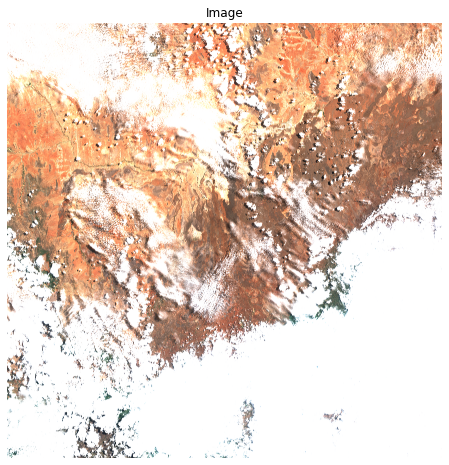

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(x)
ax.axis("off")
ax.set_title("Image")

In [104]:
B08 = items[0].assets["B08"]["href"]
R = items[0].assets["B04"]["href"]
B08, R

('https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B08.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/N/CA/2022/8/S2B_37NCA_20220826_0_L2A/B04.tif')

In [105]:
# (B08 - B04) / ((B08 + B04) + 1e-10)
# NDVI stuff
B04 = rio.open(B08).read()
B08 = rio.open(R).read()

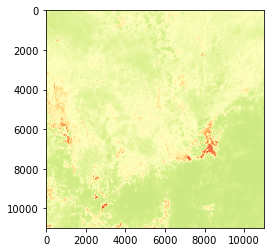

<AxesSubplot:>

In [111]:
ndvi = (B08.astype(float) - B04.astype(float)) / (
    (B08.astype(float) + B04.astype(float)) + 1e-10
)
show(ndvi, cmap="RdYlGn")

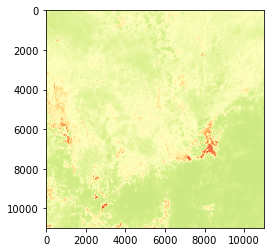

<AxesSubplot:>

In [112]:
ndvi = (B08.astype(float) - B04.astype(float)) / (
    (B08.astype(float) + B04.astype(float))
)
show(ndvi, cmap="RdYlGn")